# Phase Change Indicator #4 (주간데이타)

In [1]:
import pandas as pd
import numpy as np

# Finance Library import
from Library import FinanceLibrary as fl

In [2]:
df = pd.read_csv("..\\Data\\KOSPI_Daily_1980data.csv", encoding="utf-8")
df.index = pd.to_datetime(df["Date"])
df_close = df["Close"]
df_close = df_close.resample("W-THU")._upsample(None).interpolate()
# 데이타 기간
df_close = df_close["2010":]

df_close = np.round(df_close/df_close[0],2)  #re-scale
KOSPI = pd.DataFrame(df_close, index=df_close.index)

In [3]:
# fl.PhaseChangeIndicator(종가,기간)
Period = 24
PCI = fl.PhaseChangeIndicator(KOSPI,Period)

In [4]:
KOSPI["PCI"] = PCI
# PCI에 사용하는 모멘텀은 "현재 종가" - "전일 종가"
KOSPI["Momentum"] = KOSPI["Close"] - KOSPI["Close"].shift(Period)

In [5]:
# Momentum > 0 이고, PCI < 20 일때 매수 
# Momentum < 0 이고, PCI > 80 일때 매도 
entry = []
for i in range(len(KOSPI)):
    if KOSPI["Momentum"][i] > 0 and KOSPI["PCI"][i] < 20:  # 하락장에서 상승으로 전환, 횡보에서 상승으로 전환
        #entry.append("Buy")
        entry.append(1)
    elif KOSPI["Momentum"][i] < 0 and KOSPI["PCI"][i] > 80:  # 상승장에서 하락으로 전환, 횡보에서 하락으로 전환
        #entry.append("Sell")
        entry.append(0)
    elif KOSPI["Momentum"][i] < 0 and KOSPI["PCI"][i] < 20:  # 하락장에서 횡보로 전환
        #entry.append("Sell")
        entry.append(0)
    elif KOSPI["Momentum"][i] > 0 and KOSPI["PCI"][i] > 80:  # 상승장에서 횡보로 전환
        #entry.append("Buy")
        entry.append(1)
    else:
        entry.append(np.NaN)  # 20과 80사이는 상태를 정의할 수 없다. 아래 코드에서 이전 상태를 유지 한다.
KOSPI["Entry"] = entry
KOSPI["Entry"][0] = 0  # 첫번째 값을 "0"으로 세팅하여 현재 매도 상태임을 명시
#KOSPI["Entry"] = KOSPI["Entry"].fillna(method="ffill")  # NaN은 횡보임으로 앞의 값으로 채움

In [6]:
KOSPI["YesterdayReturn"] = np.round(fl.YesterdayReturn(KOSPI["Close"]),2)
KOSPI["YesterdayReturn"].iloc[0] = 1
# 매무 중요 진입 시그널은 어제것을 사용한다. 왜? 수익이 "어제 진입해서 오늘 확증"되는 수익률 임으로
KOSPI["TestingReturn"] = np.round(KOSPI["YesterdayReturn"] * KOSPI["Entry"].shift(1),2)
sim = fl.SimpleMomentum(KOSPI["Close"],Period)
KOSPI["MomentumReturn"] = np.round(KOSPI["YesterdayReturn"] * sim.shift(1),2)
KOSPI["MomentumReturn"].iloc[0] = 1

In [7]:
#cumprod 할때 "0"이 있으면 무조건 수익률이 0으로 나옴으로 "0"을 제거하는 코드 필요함.
KOSPI["TestingReturn"] = KOSPI["TestingReturn"].apply(lambda x: np.NaN if x == 0 else x)
KOSPI["TestingReturn"].iloc[0] = 1

<function matplotlib.pyplot.show>

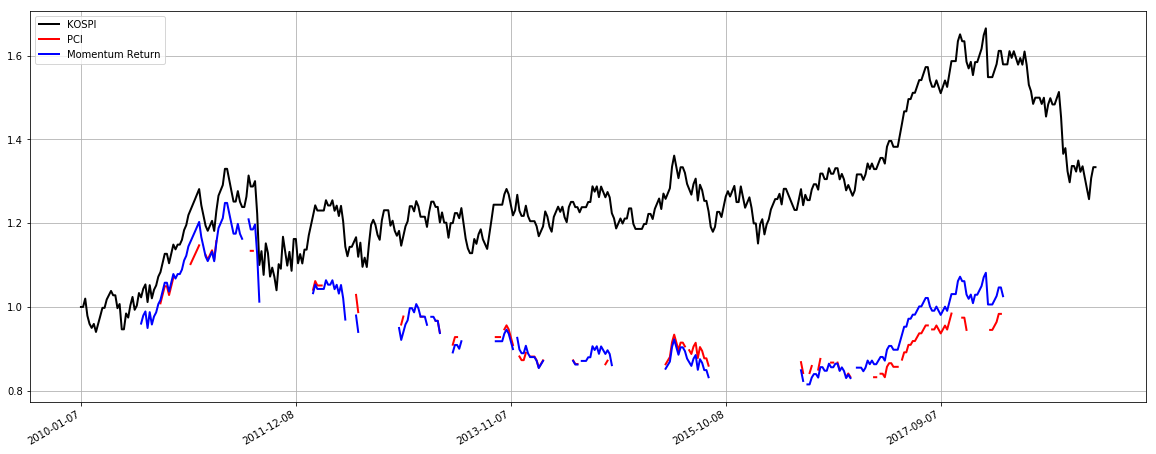

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,8)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'r'
plt.rcParams['axes.grid'] = True 

formatter = fl.MyFormatter(KOSPI.index)

fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(formatter)
ax.plot(np.arange(len(KOSPI)), KOSPI["YesterdayReturn"].cumprod(), color="Black", label="KOSPI")
ax.plot(np.arange(len(KOSPI)), KOSPI["TestingReturn"].cumprod(), color="Red", label="PCI")
ax.plot(np.arange(len(KOSPI)), KOSPI["MomentumReturn"].cumprod(), color="Blue", label="Momentum Return")
fig.autofmt_xdate()
ax.legend()
plt.show

In [9]:
a = fl.Portfolio(KOSPI["TestingReturn"].cumprod(),"PCI")
b = fl.Portfolio(KOSPI["MomentumReturn"].cumprod(),"MomentumReturn")
c = fl.Portfolio(KOSPI["YesterdayReturn"].cumprod(),"KOSPI")
d = pd.concat([a,b,c], axis=1)
d.T

,Initial Balnce,Final Balance,CAGR,Std,Max.Drawdown,Sharpe Ratio
PCI,1.0,0.983502,-0.1847,0.086623,-28.0853,0.003472
MomentumReturn,1.0,1.005193,0.0576,0.104402,-34.7093,0.010485
KOSPI,1.0,1.333824,2.9224,0.151408,-24.4977,0.039822


In [10]:
KOSPI

,Close,Momentum,PCI,Entry,YesterdayReturn,TestingReturn,MomentumReturn
Date,,,,,,,
2010-01-07,1.00,NaN,0.00,0.0,1.00,1.00,1.00
2010-01-14,1.00,NaN,0.00,NaN,1.00,NaN,NaN
2010-01-21,1.02,NaN,0.00,NaN,1.02,NaN,NaN
2010-01-28,0.98,NaN,0.00,NaN,0.96,NaN,NaN
2010-02-04,0.96,NaN,0.00,NaN,0.98,NaN,NaN
2010-02-11,0.95,NaN,0.00,NaN,0.99,NaN,NaN
2010-02-18,0.96,NaN,0.00,NaN,1.01,NaN,NaN
2010-02-25,0.94,NaN,0.00,NaN,0.98,NaN,NaN
2010-03-04,0.96,NaN,0.00,NaN,1.02,NaN,NaN
